In [2]:
# Wichtig!
! pip install opencv-python==4.5.4.60

import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
import pandas as pd
from os import listdir
from os.path import isfile, join
import pytesseract
import traceback
import time
from thefuzz import fuzz


  Using cached opencv_python-4.5.4.60-cp39-cp39-win_amd64.whl (35.1 MB)


In [3]:
#img = cv2.imread(r"D:\5_Integrationsseminar\Aufnahmen\still92.jpg")
img = cv2.imread(r"./data/small/KZE_008.jpg")
dir=r"./data/small"
dir_cropped=r"./data/cropped"
images = [f for f in listdir(dir) if isfile(join(dir, f))]

#C:/Users/Kilian/Notebook/5_Semster/test_plates_kaggle/IMG_4134.jpg
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

In [4]:
# initializing Dataframe
df = pd.DataFrame(columns=['Image', 'Cropping', 'Text_easyocr','Text_pytesseract', 'Time_cropping', 'Time_easyOCR', 'Time_tesseract'])
df.Image=images

labels = pd.read_csv("./data/labels.csv", sep=";")
df = df.merge(labels, on="Image")

In [5]:
df[:5]


,Image,Cropping,Text_easyocr,Text_pytesseract,Time_cropping,Time_easyOCR,Time_tesseract,Text_label
0,KZE_001.jpg,NaN,NaN,NaN,NaN,NaN,NaN,SG GE 567
1,KZE_002.jpg,NaN,NaN,NaN,NaN,NaN,NaN,K BA 4773
2,KZE_003.jpg,NaN,NaN,NaN,NaN,NaN,NaN,MA OV 7575
3,KZE_004.jpg,NaN,NaN,NaN,NaN,NaN,NaN,MA A 114
4,KZE_005.jpg,NaN,NaN,NaN,NaN,NaN,NaN,MA PP 444E


In [6]:
easyocr_reader = easyocr.Reader(['en']) # Funktioniert in diesem Fall besser als Deutsch
pytesseract.pytesseract.tesseract_cmd = r"C:\Users\misarasa\AppData\Local\Programs\Tesseract-OCR\tesseract.exe" # Bitte anpassen

for n, i in enumerate(images):
    time_start = time.time()
    path=(r"./data/small/"+i)
    print(path)
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction mit geringem Einfluss auf die Kanten
    edged = cv2.Canny(bfilter, 30, 100) # Kantenerkennung
    #plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
    #plt.show()
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break

    mask = np.zeros(gray.shape, np.uint8)
    
    try:
        new_image = cv2.drawContours(mask, [location], 0,255, -1)
        new_image = cv2.bitwise_and(img, img, mask=mask)
        #ab hier nummern
        # plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        # plt.show()
        

        (x,y) = np.where(mask==255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        # cropped_image = gray[x1:x2+1, y1:y2+1] # cOdEqUalItÄt
        cropped_image = new_image[x1:x2+1, y1:y2+1]
        df.iloc[n,1]=("Okay")
        cv2.imwrite((r"./data/cropped/"+i+'_cropped.jpg'), cropped_image)#   cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        df.iloc[n,4] = time.time() - time_start # time_cropping
        try: # ------- EasyOCR -------
            easyocr_result = easyocr_reader.readtext(cropped_image, min_size = 40, allowlist = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789ÜÖA")
            # print('EasyOCR Ergbnis Raw: ',result)
            easyocr_text=''
            for x in easyocr_result:
                easyocr_text=easyocr_text+x[1]+" "
            print("easyOCR Ergebnis: ", easyocr_text)
            df.iloc[n,2] = easyocr_text
            df.iloc[n,5] = time.time() - time_start #time_easyocr
        except:
            print("easyOCR Fehler")
            df.iloc[n,2] = "Fehler_EasyOCR"
            print(traceback.format_exc())
            df.iloc[n,5] = time.time() - time_start #time_easyocr
         
        try: # ------- Tesseract -------
            tesseract_result = pytesseract.image_to_string(cropped_image, lang='deu', config='--psm 7') # Ganzes Bild wird als eine Zeile Text behandelt
            print("Tesseract Ergebnis: ", tesseract_result)
            df.iloc[n,3] = tesseract_result
            df.iloc[n,6] = time.time() - time_start #time_tesseract
        except:
            print("Tesseract Fehler")
            print(traceback.format_exc())
            df.iloc[n,3] = "Fehler_Tesseract"
            df.iloc[n,6] = time.time() - time_start #time_tesseract
        
    except:
        print("Fehler Cropping")
        df.iloc[n,1]="Fehler"
        df.iloc[n,4] = time.time() - time_start
    print("\n----------------------------------------------------------")
        
    

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


./data/small/KZE_001.jpg
easyOCR Ergebnis:  
Tesseract Ergebnis:  DR


----------------------------------------------------------
./data/small/KZE_002.jpg
easyOCR Ergebnis:  
Tesseract Ergebnis:  N


----------------------------------------------------------
./data/small/KZE_003.jpg
Fehler Cropping

----------------------------------------------------------
./data/small/KZE_004.jpg
easyOCR Ergebnis:  MASA114 
Tesseract Ergebnis:  MA®A114|


----------------------------------------------------------
./data/small/KZE_005.jpg
Fehler Cropping

----------------------------------------------------------
./data/small/KZE_006.jpg
easyOCR Ergebnis:  
Tesseract Ergebnis:  ra


----------------------------------------------------------
./data/small/KZE_007.jpg
easyOCR Ergebnis:  
Tesseract Ergebnis:  Fl


----------------------------------------------------------
./data/small/KZE_008.jpg
easyOCR Ergebnis:  MA LI174 
Tesseract Ergebnis:  MAsLI 174


------------------------------------------------

In [7]:
df.to_pickle("./data/eval_df.pkl")

In [8]:
df = pd.read_pickle("./data/eval_df.pkl")
print("Durchschnittliche Zeit zum Croppen:", df["Time_cropping"].mean(), "Sekunden")
print("Durchschnittlich benötigte Zeit für easyOCR:", df["Time_easyOCR"].mean(), "Sekunden")
print("Durchschnittlich benötigte Zeit für Tesseract:", df["Time_tesseract"].mean(), "Sekunden")



Durchschnittliche Zeit zum Croppen: 1.1354429358142917 Sekunden
Durchschnittlich benötigte Zeit für easyOCR: 1.9269675787757425 Sekunden
Durchschnittlich benötigte Zeit für Tesseract: 2.2583264603334317 Sekunden


In [9]:
# for index, row in df.iterrows(): # easyOCR
#     df.iloc[index, 4] = fuzz.partial_ratio(str(df.iloc[index, 2]), str(df.iloc[index, 6]))
# for index, row in df.iterrows(): # tesseract
#     df.iloc[index, 5] = fuzz.partial_ratio(str(df.iloc[index, 3]), str(df.iloc[index, 6]))

In [10]:
df = pd.read_pickle("./data/eval_df.pkl")

def evaluate(score_func, name, thresh=55):
    # Calculating scores
    df.insert(len(df.columns), name+"_easyOCR", None)
    df.insert(len(df.columns), name+"_tesseract", None)

    for index, row in df.iterrows(): # easyOCR
        df.iloc[index, len(df.columns)-2] = score_func(str(df.iloc[index, 2]), str(df.iloc[index, 7]))
    for index, row in df.iterrows(): # tesseract
        df.iloc[index, len(df.columns)-1] = score_func(str(df.iloc[index, 3]), str(df.iloc[index, 7]))
    # Plotting
    plt.axhline(y=thresh, color="green", linestyle="--")

    df_plot = df[df["Cropping"]=="Okay"] # We're evaluating OCR, ignore the cases where OCR didn't happen
    df_plot.sort_values(name+"_easyOCR", ascending=False)[name+"_easyOCR"].plot(use_index=False, color="#ff3503") # Electric Orange
    len_correct = len(df_plot[df_plot[name+"_easyOCR"] >= thresh])
    print(f"Mit der Bewertung {name} und einem Threshold {thresh} hat EasyOCR {len_correct} von {len(df_plot)} Kennzeichen richtig erkannt")

    df_plot = df[df["Cropping"]=="Okay"] # We're evaluating OCR, ignore the cases where OCR didn't happen
    df_plot.sort_values(name+"_tesseract", ascending=False)[name+"_tesseract"].plot(use_index=False, color = "Teal")
    len_correct = len(df_plot[df_plot[name+"_tesseract"] >= thresh])
    print(f"Mit der Bewertung {name} und einem Threshold {thresh} hat Tesseract {len_correct} von {len(df_plot)} Kennzeichen richtig erkannt")
    # print(df_plot_easyOCR[name+"_easyOCR"])
    # df_plot_tesseract = df_plot.sort_values(name+"_tesseract", ascending=False)
    # plt.plot(df_plot_tesseract[name+"_tesseract"])
    plt.legend(["Threshold", "easyOCR", "Tesseract"])

def custom_match(read, label):
    for x in label:
        if x not in read:
            return 0
    return 100

In [11]:
print("Es wurden ",len(df[df["Cropping"]=="Okay"])," von ",len(df)," Kennzeichen eingegrenzt")

Es wurden  85  von  118  Kennzeichen eingegrenzt


Mit der Bewertung Partial_Ratio und einem Threshold 45 hat EasyOCR 31 von 85 Kennzeichen richtig erkannt
Mit der Bewertung Partial_Ratio und einem Threshold 45 hat Tesseract 22 von 85 Kennzeichen richtig erkannt


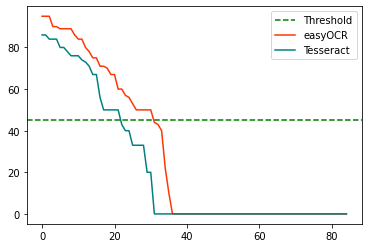

In [12]:
evaluate(fuzz.partial_ratio, "Partial_Ratio", 45)

Mit der Bewertung Fuzzy_Ratio und einem Threshold 45 hat EasyOCR 28 von 85 Kennzeichen richtig erkannt
Mit der Bewertung Fuzzy_Ratio und einem Threshold 45 hat Tesseract 17 von 85 Kennzeichen richtig erkannt


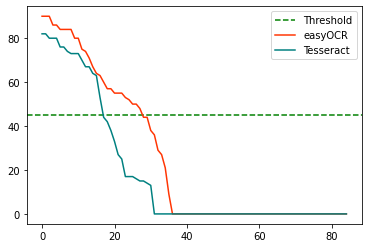

In [13]:
evaluate(fuzz.ratio, "Fuzzy_Ratio", 45)

Mit der Bewertung custom_match und einem Threshold 45 hat EasyOCR 21 von 85 Kennzeichen richtig erkannt
Mit der Bewertung custom_match und einem Threshold 45 hat Tesseract 5 von 85 Kennzeichen richtig erkannt


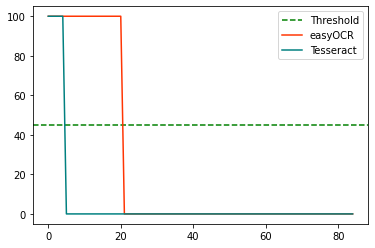

In [14]:
evaluate(custom_match, "custom_match", 45)

In [15]:
df[df["Cropping"] == "Okay"]

,Image,Cropping,Text_easyocr,Text_pytesseract,Time_cropping,Time_easyOCR,Time_tesseract,Text_label,Partial_Ratio_easyOCR,Partial_Ratio_tesseract,Fuzzy_Ratio_easyOCR,Fuzzy_Ratio_tesseract,custom_match_easyOCR,custom_match_tesseract
0,KZE_001.jpg,Okay,,DR\n,0.584538,0.910406,1.514661,SG GE 567,0,0,0,0,0,0
1,KZE_002.jpg,Okay,,N\n,0.573678,0.78573,0.99417,K BA 4773,0,0,0,0,0,0
3,KZE_004.jpg,Okay,MASA114,MA®A114|\n,0.510198,1.497868,1.778344,MA A 114,75,71,71,67,100,0
5,KZE_006.jpg,Okay,,ra\n,0.460516,0.629093,0.837603,MA SF 645,0,0,0,0,0,0
6,KZE_007.jpg,Okay,,Fl\n,0.986119,1.151162,1.490137,MA H 4000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,KZE_112.jpg,Okay,,5\n,0.558153,0.612644,0.827186,SIG P 910,0,0,0,0,0,0
112,KZE_113.jpg,Okay,SP AT2,,1.018906,2.25605,2.580899,SP AT 29,86,0,75,0,0,0
113,KZE_114.jpg,Okay,MH2211,MASAL 2911\n,0.500605,1.406875,1.736434,MA AI 2911,43,76,44,73,0,0
115,KZE_116.jpg,Okay,MA EET223,MA®EE 1923\n,0.562784,1.49126,1.817962,MA EE 1923,70,86,67,82,0,100
